In [1]:
import librosa 
import soundfile
import os, glob, pickle
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [2]:
labels = ['Neutral','Disgust','Fear','Sadness', 'Anger', 'Happiness', 'Surprise']

In [3]:
root_path=os.path.join('FER','workspace')
video_path=os.path.join(root_path,'video')
audio_path=os.path.join('FER','audio')
img_path=os.path.join(root_path,'image','collected_img')
aug_img_path=os.path.join(root_path,'image','augmented_img')
train_path=os.path.join(root_path,'train')
train_aug_path=os.path.join(root_path,'train-aug')
test_path=os.path.join(root_path,'test')
validate_path=os.path.join(root_path,'validate')
model_path=train=os.path.join(root_path,'model')

In [4]:
# !pip install soundfile
# !pip install librosa
# !pip install resampy

<pre>
mfccs
before transpose mfcc (40, 167)
after transpose mfcc (167, 40)
mfcc.shape (40,)
chroma
before transpose mfcc (12, 167)
after transpose chroma (167, 12)
chroma.shape (12,)
mel
before transpose mel (128, 167)
after transpose mel (167, 128)
mel.shape (128,)
</pre>

In [9]:
def extract_feature(file_name, mfcc, chroma, mel):
    X, sample_rate=librosa.load(os.path.join(file_name), res_type='kaiser_fast') 
    if chroma:
        stft=np.abs(librosa.stft(X))
    result=np.array([])
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0) 
        result=np.hstack((result, mfccs))
    if chroma:
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
    if mel:
        mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
        
#     onset_env = librosa.onset.onset_strength(y=X, sr=sample_rate)
#     tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sample_rate)
#     print(tempo.shape,tempo)
    return result

In [10]:
def load_data(test_size=0.2):
    x,y=[], []
    for label in os.listdir(audio_path):
        for audio_file in os.listdir(os.path.join(audio_path,label)):
            emotion=audio_file.split('-')[0]
            if emotion not in labels:
                continue
            feature=extract_feature(os.path.join(audio_path,label,audio_file), mfcc=True, chroma=True, mel=True)
#             print(len(feature),feature)
            x.append(feature)
            y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, train_size= 0.75, random_state=9)


# Loading the audio data into train test

In [ ]:
# Split the Dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.15)

In [56]:
print((x_train.shape, x_test.shape))
print(len(y_train),len(y_test))
x_train[0].shape

((1069, 180), (214, 180))
1069 214


(180,)

# Label Encoding

In [57]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

#Encode emotion labels into numbers
# print(lb.fit_transform(y_train))
y_train_lb =np_utils.to_categorical(lb.fit_transform(y_train))
y_test_lb = np_utils.to_categorical(lb.fit_transform(y_test))

# Check out the data
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train_lb.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test_lb.shape}')

x_train shape: (1069, 180)
y_train shape: (1069, 7)
x_test shape: (214, 180)
y_test shape: (214, 7)


In [58]:
y_train_lb

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

# Normalize the data

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
print(x_train_scaled.shape,x_test_scaled.shape)

(1069, 180) (214, 180)


In [60]:
print('before scaling',x_train[0][:10])
print('after scaling',x_train_scaled[0][:10])

before scaling [-539.17907715   36.34679031  -19.77251244    3.99572039  -15.84661007
   -7.81786203   -8.87937832   -7.97888851  -11.06785393   -2.29772043]
after scaling [ 0.28008378 -0.86088113 -0.6998665  -0.83783779 -1.34214062 -0.80019866
  0.17012676 -0.41963053 -0.16348596 -0.47866227]


# MLP 

In [182]:
model=MLPClassifier (alpha=0.001, batch_size=4, epsilon=1e-08, hidden_layer_sizes=(800,), learning_rate='adaptive', max_iter=500)
model.fit(x_train,y_train_lb)

MLPClassifier(alpha=0.001, batch_size=4, hidden_layer_sizes=(800,),
              learning_rate='adaptive', max_iter=500)

In [183]:
# Predict for the test set
y_train_pred=model.predict(x_train)
accuracy=accuracy_score (y_true=y_train_lb, y_pred=y_train_pred)
print("Train Accuracy: {:.2f}%".format(accuracy*100))

y_test_pred=model.predict(x_test)
accuracy=accuracy_score (y_true=y_test_lb, y_pred=y_test_pred)
print("Test Accuracy: {:.2f}%".format(accuracy*100))

Train Accuracy: 87.27%
Test Accuracy: 34.60%


In [185]:
from sklearn.metrics import classification_report 

lst=lb.inverse_transform([0,1,2,3,4,5,6])
for i in range(0,7):
    print(i," : ",lst[i])
print(classification_report (y_test_lb,y_pred))

0  :  Anger
1  :  Disgust
2  :  Fear
3  :  Happiness
4  :  Neutral
5  :  Sadness
6  :  Surprise
              precision    recall  f1-score   support

           0       0.61      0.66      0.63        29
           1       0.60      0.07      0.13        41
           2       0.44      0.29      0.35        28
           3       0.44      0.21      0.29        38
           4       0.33      0.81      0.47        16
           5       0.47      0.27      0.35        33
           6       0.67      0.38      0.49        26

   micro avg       0.48      0.33      0.39       211
   macro avg       0.51      0.38      0.39       211
weighted avg       0.52      0.33      0.36       211
 samples avg       0.30      0.33      0.31       211



C:\Users\mansi\anaconda3\envs\tfod1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [186]:
from joblib import Parallel, delayed 
import joblib 

joblib.dump(model, 'MLP-1.pkl') 
  
# Load the model from the file 
MLP_model = joblib.load('MLP-1.pkl')  
MLP_model.predict(x_test)  

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

# CNN 

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D, Activation, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import h5py

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [62]:
CNN_model = Sequential()

#Build first layer
CNN_model.add(Conv1D(16, 5,padding='same',input_shape=(180, 1), activation='relu'))
CNN_model.add(BatchNormalization())

#Build second layer
CNN_model.add(Conv1D(32, 5,padding='same',activation='relu'))
CNN_model.add(BatchNormalization())

#Build third layer
CNN_model.add(Conv1D(64, 5,padding='same',activation='relu'))
CNN_model.add(BatchNormalization())

#Add dropout
CNN_model.add(Dropout(0.1))

#Build forth layer
CNN_model.add(Conv1D(128, 5,padding='same',activation='relu'))
CNN_model.add(BatchNormalization())

#Build forth layer
CNN_model.add(Conv1D(256, 5,padding='same',activation='relu'))
CNN_model.add(BatchNormalization())

# CNN_model.add(MaxPooling1D(pool_size=5))

#Flatten 
CNN_model.add(Flatten())

CNN_model.add(Dense(128, activation ='relu'))
CNN_model.add(Dropout(0.4))
CNN_model.add(Dense(64, activation ='relu'))
CNN_model.add(Dense(7, activation='softmax'))

In [63]:
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 180, 16)           96        
                                                                 
 batch_normalization_5 (Batc  (None, 180, 16)          64        
 hNormalization)                                                 
                                                                 
 conv1d_6 (Conv1D)           (None, 180, 32)           2592      
                                                                 
 batch_normalization_6 (Batc  (None, 180, 32)          128       
 hNormalization)                                                 
                                                                 
 conv1d_7 (Conv1D)           (None, 180, 64)           10304     
                                                                 
 batch_normalization_7 (Batc  (None, 180, 64)         

In [64]:
CNN_model.compile(loss = 'categorical_crossentropy',
                  optimizer =Adam(lr=0.000001),
                  metrics = ['accuracy'])

C:\Users\mansi\anaconda3\envs\tfod1\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [68]:
cnn_results = CNN_model.fit(x_train, y_train_lb,
              batch_size = 32,
              epochs = 400,
              verbose = 1,
              validation_data = (x_test, y_test_lb))

Epoch 1/400
34/34 [==============================] - 1s 38ms/step - loss: 0.4632 - accuracy: 0.8569 - val_loss: 1.6093 - val_accuracy: 0.4533
Epoch 2/400
34/34 [==============================] - 1s 28ms/step - loss: 0.4516 - accuracy: 0.8737 - val_loss: 1.5790 - val_accuracy: 0.4579
Epoch 3/400
34/34 [==============================] - 1s 28ms/step - loss: 0.4659 - accuracy: 0.8531 - val_loss: 1.5525 - val_accuracy: 0.4626
Epoch 4/400
34/34 [==============================] - 1s 27ms/step - loss: 0.4680 - accuracy: 0.8662 - val_loss: 1.5381 - val_accuracy: 0.4766
Epoch 5/400
34/34 [==============================] - 1s 27ms/step - loss: 0.4533 - accuracy: 0.8700 - val_loss: 1.5319 - val_accuracy: 0.4766
Epoch 6/400
34/34 [==============================] - 1s 26ms/step - loss: 0.4510 - accuracy: 0.8550 - val_loss: 1.5541 - val_accuracy: 0.4579
Epoch 7/400
34/34 [==============================] - 1s 27ms/step - loss: 0.4603 - accuracy: 0.8634 - val_loss: 1.5378 - val_accuracy: 0.4579
Epoch 

34/34 [==============================] - 1s 24ms/step - loss: 0.3778 - accuracy: 0.8868 - val_loss: 1.5893 - val_accuracy: 0.4579
Epoch 116/400
34/34 [==============================] - 1s 24ms/step - loss: 0.3837 - accuracy: 0.8934 - val_loss: 1.5691 - val_accuracy: 0.4766
Epoch 117/400
34/34 [==============================] - 1s 24ms/step - loss: 0.3680 - accuracy: 0.8821 - val_loss: 1.5961 - val_accuracy: 0.4720
Epoch 118/400
34/34 [==============================] - 1s 24ms/step - loss: 0.3518 - accuracy: 0.8952 - val_loss: 1.5808 - val_accuracy: 0.4720
Epoch 119/400
34/34 [==============================] - 1s 25ms/step - loss: 0.3893 - accuracy: 0.8784 - val_loss: 1.5720 - val_accuracy: 0.4673
Epoch 120/400
34/34 [==============================] - 1s 24ms/step - loss: 0.3521 - accuracy: 0.8990 - val_loss: 1.5886 - val_accuracy: 0.4626
Epoch 121/400
34/34 [==============================] - 1s 24ms/step - loss: 0.3361 - accuracy: 0.9130 - val_loss: 1.6133 - val_accuracy: 0.4626
Epoch 

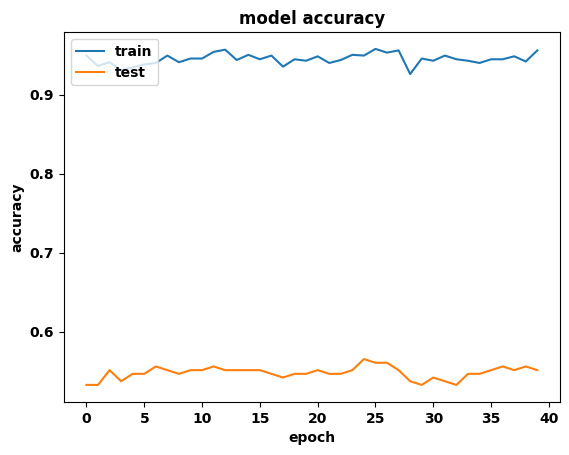

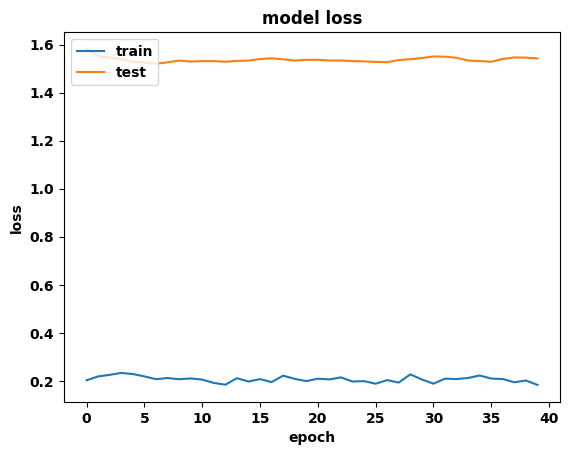

In [48]:
from matplotlib import pyplot as plt
# Accuracy
# epochs = range(1, len(acc) + 1)
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# LOSS
plt.plot(cnn_results.history['loss'])
plt.plot(cnn_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
CNN_model.save('cnn_model_audio-4(acc=89.5,val=52).h5')

# SVM

In [258]:
from sklearn import svm

In [295]:
lb1 = LabelEncoder()

#Encode emotion labels into numbers
# print(lb.fit_transform(y_train))
y_train_lb1 =lb1.fit_transform(y_train)
y_test_lb1 = lb1.fit_transform(y_test)

# Check out the data
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train_lb1.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test_lb1.shape}')

x_train shape: (1069, 180)
y_train shape: (1069,)
x_test shape: (214, 180)
y_test shape: (214,)


In [293]:
svm_classifier1 = svm.SVC(kernel='linear')  # You can use 'rbf' or other kernels as well

# Train the SVM classifier
# y_train_lb1=y_train_lb.reshape(-1)
# print(y_train_lb1)
svm_classifier1.fit(x_train, y_train_lb1)

# Make predictions on the test set
y_pred1 = svm_classifier1.predict(x_train)

# Evaluate the accuracy
accuracy1 = accuracy_score(y_train_lb1, y_pred1)
print(f"Train Accuracy: {accuracy1 * 100:.2f}%")

# Make predictions on the test set
y_pred2 = svm_classifier1.predict(x_test)

# Evaluate the accuracy
accuracy2 = accuracy_score(y_test_lb1, y_pred2)
print(f"Test Accuracy: {accuracy2 * 100:.2f}%")

Train Accuracy: 72.50%
Test Accuracy: 33.18%


In [294]:
svm_classifier2 = svm.SVC(kernel='linear')
svm_classifier2.fit(x_train_scaled, y_train_lb1)

# Make predictions on the test set
y_pred1 = svm_classifier2.predict(x_train_scaled)

# Evaluate the accuracy
accuracy1 = accuracy_score(y_train_lb1, y_pred1)
print(f"Train Accuracy: {accuracy1 * 100:.2f}%")

# Make predictions on the test set
y_pred2 = svm_classifier2.predict(x_test_scaled)

# Evaluate the accuracy
accuracy2 = accuracy_score(y_test_lb1, y_pred2)
print(f"Test Accuracy: {accuracy2 * 100:.2f}%")

Train Accuracy: 77.17%
Test Accuracy: 35.51%
